# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pysra

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pysra.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pysra.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pysra.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pysra.site.Profile(
    [
        pysra.site.Layer(
            pysra.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pysra.site.Layer(
            pysra.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pysra.site.Layer(
            pysra.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pysra.site.Layer(pysra.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pysra.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pysra.variation.ToroThicknessVariation()
var_velocity = pysra.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pysra.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30
)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection(
    [
        pysra.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pysra.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pysra.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pysra.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pysra.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pysra.output.InitialVelProfile(),        
        pysra.output.MaxAccelProfile()
    ]
)

## Perform the calculation

In [8]:
count = 20
outputs.reset()
for i, p in enumerate(
    pysra.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

[ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
 10.         12.         14.         16.         18.         20.
 23.33333333 26.66666667 30.         33.33333333 36.66666667 40.
 43.33333333 46.66666667 50.        ] [0.03488483797299778, 0.03436782813180201, 0.032934869850776975, 0.030929418512517872, 0.028841163625894943, 0.027054387431520728, 0.025608097369810956, 0.024512493296119535, 0.02335568284756965, 0.022223274912010316, 0.021238356545003736, 0.02051956454311927, 0.01997443430916329, 0.019281256778986337, 0.018526771882076996, 0.017759686844604, 0.0169728559381334, 0.016155119732995424, 0.015350283145350276, 0.014700684666519253, 0.014429852112479047]
[ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
 10.         12.         14.         16.         18.         20.
 23.33333333 26.66666667 30.         33.33333333 36.66666667 40.
 43.33333333 46.66666667 50.        ] [0.09624781910426528, 0.09504354324668435, 0.09166068053891825, 0

[ 0.          1.25        2.5         3.75        5.          6.25
  7.5         8.75       10.         11.42857143 12.85714286 14.28571429
 15.71428571 17.14285714 18.57142857 20.         21.66666667 23.33333333
 25.         26.66666667 28.33333333 30.         31.66666667 33.33333333
 35.         36.66666667 38.33333333 40.         41.66666667 43.33333333
 45.         46.66666667 48.33333333 50.        ] [0.10833544103382585, 0.10713709260753734, 0.10375650536515549, 0.0989868035690299, 0.09397171880390713, 0.08954492314231476, 0.08584223906693168, 0.08279984687384453, 0.08049795743060088, 0.07899632680124384, 0.07736787243041933, 0.0757534483268399, 0.07426579342097811, 0.07296296569208655, 0.07188352130825848, 0.07106172194140076, 0.07033281597032888, 0.06948296515716154, 0.06862363140501757, 0.06783625563539356, 0.0671292231767946, 0.06645494487538883, 0.06574628734184051, 0.06494138392220701, 0.063991670540922, 0.06285878752638098, 0.06149961781859509, 0.05984994461056323, 0.05783

[ 0.          1.25        2.5         3.75        5.          6.25
  7.5         8.75       10.         11.42857143 12.85714286 14.28571429
 15.71428571 17.14285714 18.57142857 20.         22.72727273 25.45454545
 28.18181818 30.90909091 33.63636364 36.36363636 39.09090909 41.81818182
 44.54545455 47.27272727 50.        ] [0.261706694467989, 0.25899115476255663, 0.2509762691206906, 0.23924228542057208, 0.2267193146485605, 0.21506764234849102, 0.2039030776519324, 0.19319162746490157, 0.18383752230472153, 0.1784018985561724, 0.17200759803690918, 0.16533084321037134, 0.15887244273429915, 0.15294083319374516, 0.1479611163368331, 0.14454108005523714, 0.14203444257626377, 0.13771871568296665, 0.1326437868867146, 0.1277086867524414, 0.12314679856348479, 0.11878209999963886, 0.11444798494392383, 0.1101665564605646, 0.10622542924108873, 0.10320275933168949, 0.10179640116464735]
[ 0.          1.11111111  2.22222222  3.33333333  4.44444444  5.55555556
  6.66666667  7.77777778  8.88888889 10.     

[ 0.          2.          4.          6.          8.         10.
 11.66666667 13.33333333 15.         16.66666667 18.33333333 20.
 22.5        25.         27.5        30.         32.5        35.
 37.5        40.         42.5        45.         47.5        50.        ] [0.03487373501906649, 0.034386918660211256, 0.03306230307267231, 0.03132720611209834, 0.029781926747324716, 0.028572384089500934, 0.02723135030777335, 0.026126330276087104, 0.025091353013939704, 0.024118812740276278, 0.023312669196316606, 0.022854384884440932, 0.02256929275426447, 0.022059274003408267, 0.02146027946498161, 0.020867392269302225, 0.02028625554750498, 0.019673018740194007, 0.018977007750696353, 0.018162442373061666, 0.017232727395140524, 0.01627162694276937, 0.01548869383334991, 0.015201995394905115]
[ 0.          2.          4.          6.          8.         10.
 11.66666667 13.33333333 15.         16.66666667 18.33333333 20.
 22.5        25.         27.5        30.         32.5        35.
 37.5        40.

[ 0.          2.          4.          6.          8.         10.
 11.66666667 13.33333333 15.         16.66666667 18.33333333 20.
 22.72727273 25.45454545 28.18181818 30.90909091 33.63636364 36.36363636
 39.09090909 41.81818182 44.54545455 47.27272727 50.        ] [0.09679899258972938, 0.09553058555810853, 0.09204429206394721, 0.08738326756739917, 0.08298604035113046, 0.07940185406877824, 0.07635107619021263, 0.07356885751412263, 0.07091142196334362, 0.06840923100837523, 0.0662453006134342, 0.06468438855036189, 0.06348189469874929, 0.06183106954360285, 0.06002644278127742, 0.05822659741282865, 0.056400190811596196, 0.05444046108285477, 0.052255806920607835, 0.04983904013160759, 0.04736669325537869, 0.0453149199980073, 0.044421490847453914]
[ 0.          2.          4.          6.          8.         10.
 11.66666667 13.33333333 15.         16.66666667 18.33333333 20.
 22.72727273 25.45454545 28.18181818 30.90909091 33.63636364 36.36363636
 39.09090909 41.81818182 44.54545455 47.2727272

[ 0.          1.42857143  2.85714286  4.28571429  5.71428571  7.14285714
  8.57142857 10.         11.42857143 12.85714286 14.28571429 15.71428571
 17.14285714 18.57142857 20.         21.76470588 23.52941176 25.29411765
 27.05882353 28.82352941 30.58823529 32.35294118 34.11764706 35.88235294
 37.64705882 39.41176471 41.17647059 42.94117647 44.70588235 46.47058824
 48.23529412 50.        ] [0.21353557697572456, 0.21202263387801354, 0.20758752220325252, 0.200914739657898, 0.19327873155337916, 0.18610211220012146, 0.18017565464694435, 0.17529853834920225, 0.17114764755609702, 0.16744353658544545, 0.164059805391448, 0.16093757429724473, 0.15812009970673968, 0.15574562841236456, 0.15400119907639515, 0.15240403771966698, 0.1501988966784378, 0.14778808999335935, 0.1455108646417506, 0.14349974769949037, 0.14170991165849783, 0.1399933336650852, 0.13817026382486736, 0.13607214786424793, 0.1335523224655026, 0.1304889040658446, 0.12680542298582304, 0.12252954297383506, 0.11790274799674484, 0.113516

## Plot the outputs

Create a few plots of the output.

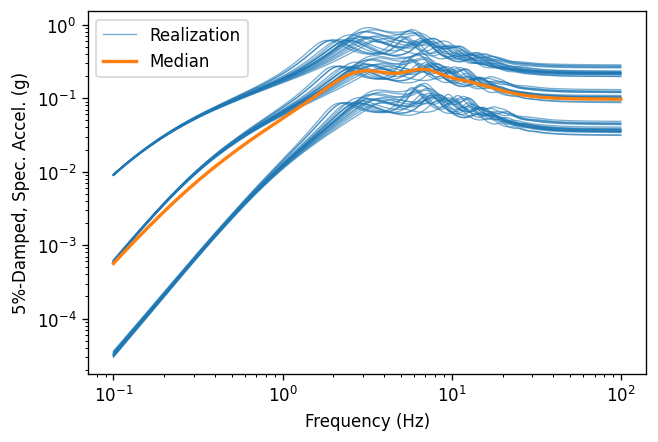

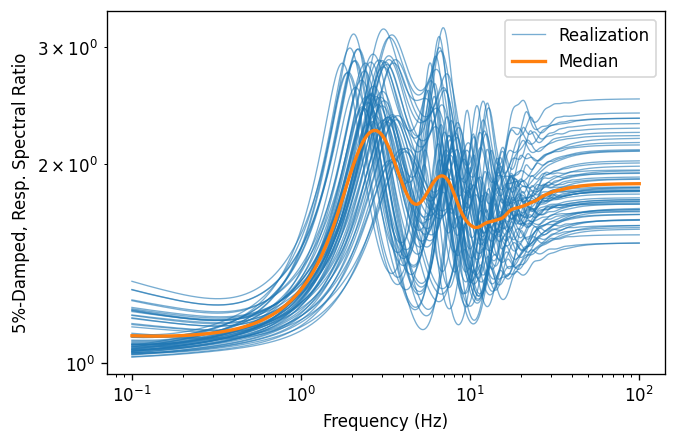

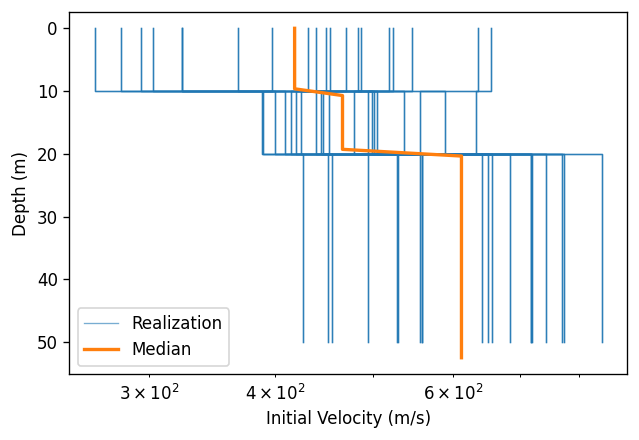

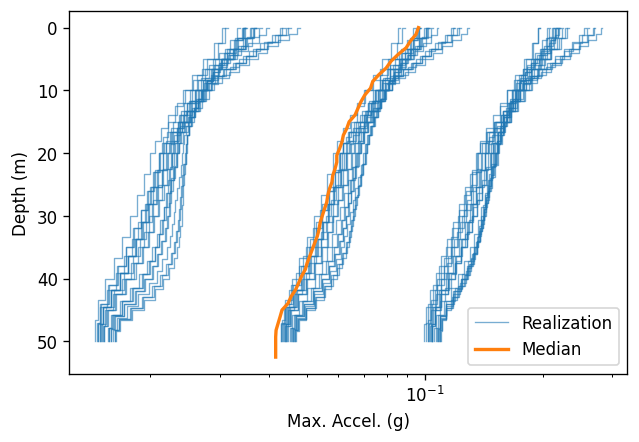

In [17]:
for o in outputs:
    ax = o.plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [11]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.101251  1.034159  1.020651  1.199307  1.066470  1.040936   
0.101394    1.100997  1.034153  1.020820  1.198594  1.066420  1.041255   
0.102807    1.100744  1.034150  1.020992  1.197883  1.066374  1.041577   
0.104240    1.100492  1.034151  1.021165  1.197175  1.066334  1.041903   
0.105693    1.100242  1.034155  1.021340  1.196470  1.066299  1.042232   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.820929  1.736271  1.691647  1.840032  1.764357  1.644441   
95.932095   1.820944  1.736273  1.691659  1.840087  1.764412  1.644512   
97.269336   1.820959  1.736275  1.691671  1.840141  1.764466  1.644581   
98.625218   1.820972  1.736277  1.691683  1.840193  1.764517  1.644648   
100.000000  1.820986  1.736279  1.691693  1.840243  1.764567  1.644713   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.241927  1.079519  1.049199  1.328402  ...  1.057471  1.201112   
0.101394    1.241002  1.079447  1.049575  1.327038  ...  1.057904  1.200386   
0.102807    1.240081  1.079380  1.049956  1.325678  ...  1.058342  1.199663   
0.104240    1.239162  1.079319  1.050340  1.324323  ...  1.058785  1.198942   
0.105693    1.238248  1.079264  1.050729  1.322972  ...  1.059233  1.198224   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   1.821845  1.754624  1.612015  2.092035  ...  1.646259  1.764214   
95.932095   1.821929  1.754710  1.612118  2.092128  ...  1.646374  1.764282   
97.269336   1.822011  1.754794  1.612218  2.092218  ...  1.646485  1.764348   
98.625218   1.822090  1.754875  1.612314  2.092305  ...  1.646592  1.764412   
100.000000  1.822167  1.754954  1.612408  2.092390  ...  1.646697  1.764474   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.067018  1.041317  1.203833  1.068313  1.042423  1.143087   
0.101394    1.066966  1.041639  1.203119  1.068261  1.042752  1.142675   
0.102807    1.066919  1.041964  1.202407  1.068214  1.043085  1.142264   
0.104240    1.066878  1.042292  1.201697  1.068173  1.043421  1.141855   
0.105693    1.066842  1.042624  1.200990  1.068136  1.043761  1.141447   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.704490  1.591827  1.897345  1.819114  1.703785  1.933632   
95.932095   1.704556  1.591908  1.897414  1.819180  1.703868  1.933673   
97.269336   1.704621  1.591987  1.897480  1.819243  1.703949  1.933713   
98.625218   1.704683  1.592063  1.897545  1.819305  1.704027  1.933752   
100.000000  1.704744  1.592137  1.897608  1.819365  1.704102  1.933789   

                                
                  m1        m2  
0.100000    1.048897  1.030216  
0.101394    1.048875  1.030458  
0.102807    1.048858  1.030702  
0.104240    1.048844  1.030949  
0.105693    1.048835  1.031198  
...              ...       ...  
94.613238   1.844676  1.775632  
95.932095   1.844706  1.775677  
97.269336   1.844735  1.775721  
98.625218   1.844763  1.775764  
100.000000  1.844790  1.775805  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [12]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.reset_index().melt(id_vars="freq")
df

,freq,profile,motion,value
0,0.100000,p0,m0,1.101251
1,0.101394,p0,m0,1.100997
2,0.102807,p0,m0,1.100744
3,0.104240,p0,m0,1.100492
4,0.105693,p0,m0,1.100242
...,...,...,...,...
29995,94.613238,p19,m2,1.775632
29996,95.932095,p19,m2,1.775677
29997,97.269336,p19,m2,1.775721
29998,98.625218,p19,m2,1.775764


In [13]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.196082  0.048252
           m1      1.066138  0.016947
           m2      1.041403  0.010951
0.101394   m0      1.195417  0.048047
           m1      1.066089  0.016921
...                     ...       ...
98.625218  m1      1.875145  0.108743
           m2      1.758625  0.105127
100.000000 m0      1.968564  0.120333
           m1      1.875201  0.108744
           m2      1.758699  0.105128

[1500 rows x 2 columns]

In [14]:
stats = (
    stats.reset_index("motion")
    .pivot(columns="motion")
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.048252  1.196082  0.016947  1.066138  0.010951  1.041403
0.101394    0.048047  1.195417  0.016921  1.066089  0.011025  1.041723
0.102807    0.047842  1.194755  0.016896  1.066044  0.011100  1.042046
0.104240    0.047638  1.194096  0.016872  1.066005  0.011176  1.042373
0.105693    0.047434  1.193438  0.016849  1.065971  0.011253  1.042703
...              ...       ...       ...       ...       ...       ...
94.613238   0.120336  1.968317  0.108741  1.874967  0.105123  1.758388
95.932095   0.120335  1.968381  0.108742  1.875029  0.105125  1.758470
97.269336   0.120335  1.968444  0.108742  1.875088  0.105126  1.758549
98.625218   0.120334  1.968505  0.108743  1.875145  0.105127  1.758625
100.000000  0.120333  1.968564  0.108744  1.875201  0.105128  1.758699

[500 rows x 6 columns]

Access the properties of each motion like:

In [15]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.048252,1.196082
0.101394,0.048047,1.195417
0.102807,0.047842,1.194755
0.104240,0.047638,1.194096
0.105693,0.047434,1.193438
...,...,...
94.613238,0.120336,1.968317
95.932095,0.120335,1.968381
97.269336,0.120335,1.968444


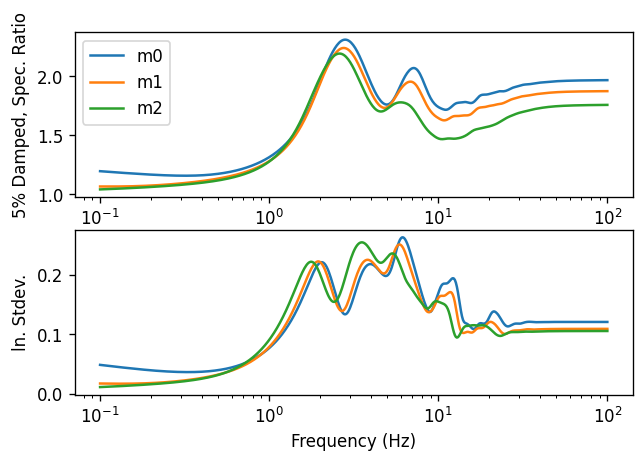

In [16]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.groupby(level=0, axis=1):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.index, g[(name, key)], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;